In [1]:
import numpy as np
import matplotlib
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
	
# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.25

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

# UPDATE 2020-12-31 (my preferred font is Avenir...)
font = {'family' : 'avenir',
    	'weight' : 'normal'}

matplotlib.rc('font', **font)
from sparrow import Protein
from sparrow.predictors import batch_predict

import protfasta

from finches import CALVADOS_frontend, Mpipi_frontend

mf = Mpipi_frontend()
cf = CALVADOS_frontend()
from sparrow import Protein

from shephard import interfaces, apis
from housetools.sequence_tools.sequence_conservation import ConservationCalculator

from tqdm import tqdm
from mutagenesis import compare, do_all_subsampling_v2



CC =  ConservationCalculator()

idr2 = 'NNNNNNDGELSGTNLRSNSIDYAKHQEISSAGTSSNTTKNVNNNKNDSNDDNNGNNNNDASNLMESVLDKTSSHRYQPKKMPSVNKWSKPDQITHSDVSMVGLDESNDGGNENVHPTLAEVDAQEARETAQLAIDKINSYKRSIDDKNGDGHNNSSRNVVDENLINDMDSEDAHKSKRQHLSDITLEERNEDDKLPHEVAEQLRLLSSHLKEVE'
rad7_idr = 'MYRSRNRPKRGGENEVKGPNSALTQFLREEGISAENIKQKWYQRQSKKQEDATDEKKGKAEDDSFTAEISRVVEDEEIDEIGTGSGTETERAQVSYDARMKLVPADSDEEEYETSHISDTPVSLSSANDRESLTKKRQNTAKIIQNRRRKRKRAADLLDRRVNKVSSLQSLCITKISENISKWQKEADESSKLVFNKLRDVLGGVST'

seq_len = len(idr2)

from scipy.stats import ks_2samp
from scipy.signal import savgol_filter

# Set rcParams for tick marks
plt.rcParams['xtick.major.size'] = 2  # Length of major ticks (in points)
plt.rcParams['xtick.minor.size'] = 1  # Length of minor ticks (in points)
plt.rcParams['xtick.major.width'] = 0.25  # Width of major ticks (in points)
plt.rcParams['xtick.minor.width'] = 0.25  # Width of minor ticks (in points)

plt.rcParams['ytick.major.size'] = 2  # Length of major ticks (in points)
plt.rcParams['ytick.minor.size'] = 1  # Length of minor ticks (in points)
plt.rcParams['ytick.major.width'] = 0.25  # Width of major ticks (in points)
plt.rcParams['ytick.minor.width'] = 0.25  # Width of minor ticks (in points)

plt.rcParams['xtick.labelsize'] = 5  # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 5  # Font size for y-axis tick labels


Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


/Users/alex/.uv/neuron_uv/.venv/lib/python3.12/site-packages/finches/forcefields/calvados.py:236: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.038286503882254706' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r.loc['H','q'] = 1. / ( 1 + 10**(self.pH-6) )


In [2]:
# read in the sequence libraries we're going to use for figure generation
new_seq_library_v2 = protfasta.read_fasta('libraries/chemlib_v2_350.fasta')
new_seq_library_null_28 = protfasta.read_fasta('libraries/chemlib_350_null_28.fasta')

mutations_real = []
mutations_null = []
for k in new_seq_library_v2:
    mutations_real.append(compare(idr2, new_seq_library_v2[k], verbose=False))

for k in new_seq_library_null_28:    
    mutations_null.append(compare(idr2, new_seq_library_null_28[k], verbose=False))
    
print(f"Real library: {np.mean(mutations_real):.2f} +/- {np.std(mutations_real):.2f} mutations per sequence")    
print(f"Null library: {np.mean(mutations_null):.2f} +/- {np.std(mutations_null):.2f} mutations per sequence")

Real library: 27.69 +/- 4.13 mutations per sequence
Null library: 27.83 +/- 2.91 mutations per sequence


In [3]:
all_real = []
all_null = []

all_real_mean = []
all_null_mean = []

log2ratio = []
n_rounds = 10
n_samples = 20
for i in range(1,n_rounds):

    X = do_all_subsampling_v2(new_seq_library_v2, 
                              new_seq_library_null_28, 
                              n_samples, 
                              idr2)    
    real_vals = X[0]
    null_vals = X[1]

    all_real.append(np.mean(real_vals,0))
    all_null.append(np.mean(null_vals,0))

    all_real_mean.append(np.mean(real_vals))
    all_null_mean.append(np.mean(null_vals))

    log2ratio.append(np.log2(np.mean(real_vals,0)/np.mean(null_vals,0)))


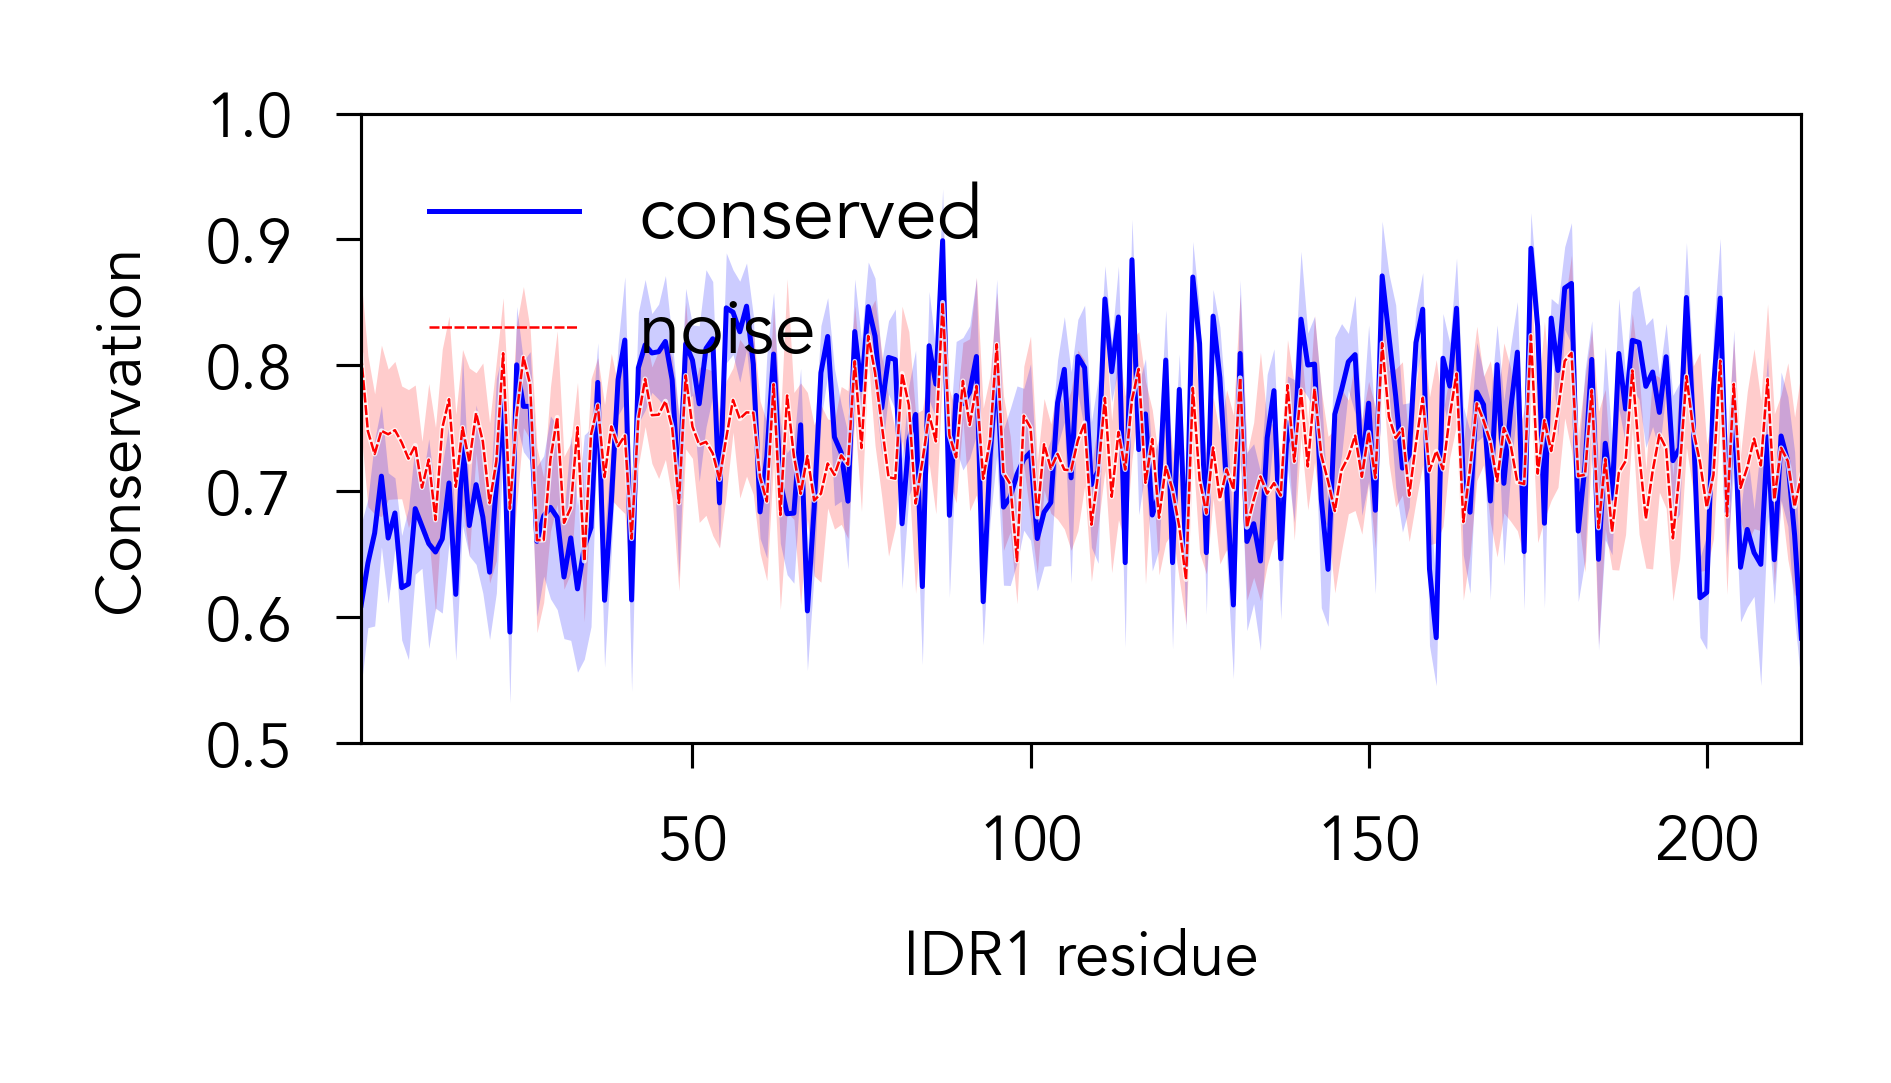

In [4]:
figure(None, (2.2,1.3), dpi=450)
indices = np.arange(1, seq_len+1)

plt.plot(indices, np.mean(all_real,0), color='b',lw=0.4, label='conserved')
plt.plot(indices, np.mean(all_null,0), color='w',lw=0.4, alpha=0.8)
plt.plot(indices, np.mean(all_null,0), color='r',lw=0.2, label='noise',linestyle=(0, (4, 1)))

mean_val = np.mean(np.array(all_null),0)
std_val  = np.std(np.array(all_null),0)

mean_val_real = np.mean(np.array(all_real),0)
std_val_real  = np.std(np.array(all_real),0)

plt.fill_between(indices,  mean_val + std_val, mean_val - std_val, color='r', alpha=0.2,lw=0)
plt.fill_between(indices,  mean_val_real + std_val_real, mean_val_real- std_val_real, color='b', alpha=0.2,lw=0)


plt.ylim([0.5,1.])
plt.xlim(1,indices[-1])
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)

plt.xlabel('IDR1 residue',fontsize=5)
plt.ylabel('Conservation',fontsize=5)

plt.legend(frameon=False, fontsize=6)
plt.tight_layout()

plt.savefig('figures/idr2_vs_rad7_noise_vs_signal.pdf')


In [ ]:
# cycle over different sample sizes
for n_samples in range(2,30,1):
    all_real = []
    all_null = []
    
    all_real_mean = []
    all_null_mean = []
    
    log2ratio = []
    n_rounds = 10
    
    for i in range(1,n_rounds):
    
        X = do_all_subsampling_v2(new_seq_library_v2, 
                                  new_seq_library_null_28, 
                                  n_samples,
                                  idr2)
        real_vals = X[0]
        null_vals = X[1]
    
        all_real.append(np.mean(real_vals,0))
        all_null.append(np.mean(null_vals,0))
    
        all_real_mean.append(np.mean(real_vals))
        all_null_mean.append(np.mean(null_vals))
    
        log2ratio.append(np.log2(np.mean(real_vals,0)/np.mean(null_vals,0)))
    
    
    figure(None, (2.2,1.3), dpi=450)
    indices = np.arange(1, seq_len+1)
    
    plt.plot(indices, np.mean(all_real,0), color='b',lw=0.4, label='conserved')
    plt.plot(indices, np.mean(all_null,0), color='w',lw=0.4, alpha=0.8)
    plt.plot(indices, np.mean(all_null,0), color='r',lw=0.2, label='noise',linestyle=(0, (4, 1)))
    
    mean_val = np.mean(np.array(all_null),0)
    std_val  = np.std(np.array(all_null),0)
    
    mean_val_real = np.mean(np.array(all_real),0)
    std_val_real  = np.std(np.array(all_real),0)
    
    plt.fill_between(indices,  mean_val + std_val, mean_val - std_val, color='r', alpha=0.2,lw=0)
    plt.fill_between(indices,  mean_val_real + std_val_real, mean_val_real- std_val_real, color='b', alpha=0.2,lw=0)
    
    
    plt.ylim([0.5,1.])
    plt.xlim(1,indices[-1])
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    
    plt.xlabel('IDR1 residue',fontsize=5)
    plt.ylabel('Conservation',fontsize=5)
    
    #plt.legend(frameon=False, fontsize=6)
    plt.tight_layout()
    plt.savefig(f'figures/signal_noise_round_samples/signal_noise_{n_rounds}_rounds_{n_samples}_orthologs.pdf')



